In [1]:
# All imports go here. Run me first!
import datetime
from pathlib import Path  # Checks for files and so on
import numpy as np  # Numpy for arrays and so on
import pandas as pd
import sys
import matplotlib.pyplot as plt  # Matplotlib for plotting
# Ensure the plots are shown in the notebook
%matplotlib inline

import gdal
import osr
import numpy as np

from geog0111.geog_data import procure_dataset
%matplotlib inline

# Fitting models of phenology to MODIS LAI data

In the previous Section, we have looked at a very simple model of phenology, probably applicable to a lot of deciduous vegetation. We have created some synthetic data, and we have tried to fit the model to these "pseudo observations". It is now the time to extract time series of MODIS data, and try to fit the model to them.

In this Section, we'll use some of the work we used before. In particular, we'll use a mosaic of LAI over Western Europe derived from the MODIS MCD15 product. The product has already been packed in an easy to use GeoTIFF file, together with the corresponding QA dataset. We'll define some functions here again (they are from other sections, but added here for simplicity):

## The phenology model

The phenology model is the double logistic/sigmoid curve, given by 

$$
y = p_0 - p_1\cdot\left[\frac{1}{1+\exp\left(p_2\cdot(t-p_3)\right)} + \frac{1}{1+\exp\left(-p_4\cdot(t-p_5)\right)} - 1\right].
$$

We also define a cost function for it based on observations of LAI, uncertainty and a mask to indicate missing observations.

In [2]:
def dbl_sigmoid_function(p, t):
    """The double sigmoid function defined over t (where t is an array).
    Takes a vector of 6 parameters"""

    sigma1 = 1./(1+np.exp(p[2]*(t-p[3])))
    sigma2 = 1./(1+np.exp(-p[4]*(t-p[5])))
    y = p[0] - p[1]*(sigma1 + sigma2 - 1)
    return y

def cost_function(p, t, y_obs, passer, sigma_obs, func=dbl_sigmoid_function):
    y_pred = func(p, t)
    cost = -0.5* (y_pred[passer]-y_obs)**2/sigma_obs**2
    return -cost.sum()

## Interpreting the QA LAI data

From before, we interpret the QA layer in the MODIS product by looking at bits 5 to 7, and turning them into a weight given by $\phi^{QA}$, where $\phi$ is the golden ratio $(=0.618\dots)$, and $QA$ can take values between 0 and 3, indicating a decreasing quality in the retrieval, and hence, a lower weight.

In [3]:
def get_sfc_qc(qa_data, mask57 = 0b11100000):
    sfc_qa = np.right_shift(np.bitwise_and(qa_data, mask57), 5)
    return sfc_qa

def get_scaling(sfc_qa, golden_ratio=0.61803398875):
    weight = np.zeros_like(sfc_qa, dtype=np.float)
    for qa_val in [0, 1, 2, 3]:
        weight[sfc_qa == qa_val] = np.power(golden_ratio, float(qa_val))
    return weight

## Selecting data from a raster file

In this activity, we want to select a pixel in the map and read in the data for all time steps. This can be achieved by plotting the map with e.g. `imshow`, and judiciously selecting a row and a column. However, in many cases, we have locations of interest as a list of latitude and longitude pairs. These do not automatically map to rows and columns, because the the MODIS data are **projected** in a projection that is not latitude/longitude. So the process of going from latitude-longitude pair to row and column needs two steps: converting latitude-longitude coordinates into the coordinates of the raster of interest (in the case of MODIS, MODIS sinusoidal projection), and then converting the raster coordinates into pixel numbers.

### Converting geographic projections

Converting from latitude-longitude pairs (or any other representation) into a different projection can be accomplished by GDAL (surprise!). We first need to find a way to defining the projection. There are several ways to do this:

* **EPSG codes** These are numerical codes that have been internationally agreed and fully define a projection
* **Proj4 strings** [Proj4](https://proj4.org/) is the library the manages coordinate conversions under the hood in GDAL. It has a method to define a projection as a text string.
* **WKT (Well-known text) format** This is a standard that defines the projection as a text block

Generally speaking, their simplicity of use recommends EPSG, a single number. In some cases, proj4 strings are best (e.g. for some product-specific projections), and WKT is generally used by other GIS software. 

In any case, the [spatialreference website](http://spatialreference.org/) provides a convenient "Rosetta stone" of projections in these different conventions. 

<div class="alert alert-danger">
<p>Use <a href="http://spatialreference.org/">spatialreference.org</a> to find out what projection the EPSG code 4326 corresponds to</p>
</div>

In Python, using the OSR part of the GDAL library, we define the source and destinations projections using `SpatialReference` objects, which are then populated with e.g. EPSG codes or proj4 strings:

```python
    import osr
    # Define the Lat/Long object
    wgs84 = osr.SpatialReference()
    # In this case, we use EPSG code
    wgs84.ImportFromEPSG(4326)
    # Define the MODIS projection object
    modis_sinu = osr.SpatialReference()
    # In this case, we use the proj4 string
    modis_sinu.ImportFromProj4("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 " + 
                           "+a=6371007.181 +b=6371007.181 +units=m +no_defs")
```

The previous code snippet defines two `SpatialReference` objects. These can be used to map from MODIS to/and from Latitude Longitude (or "WGS84") coordinates by using the `osr.CoordinateTransformation` object:

```python
    transformation = osr.CoordinateTransformation(wgs84, modis_sinu)
    modis_x, modis_y, modis_z = transformation.TransformPoint(longitude,
                                                              latitude)
```

Clearly, changing the order of the parameters in `osr.CoordinateTransformation` would reverse the transformation.

<div class="alert alert-danger">
<p>Write some python code to convert the location of the Pearson Building (latitude: 51.524750 decimal degrees, longitude=-0.134560 decimal degrees) between WGS84 and OSGB 1936/British National Grid and UTM zone 30N/WGS84. Use <a href="https://mygeodata.cloud/cs2cs/">mygeodata.cloud</a> to test that your results are sensible</p>
</div>


### Finding a pixel based on its coordinates

Geospatial data usually contain a definition of how to go from a coordinate to a pixel location. In GDAL, the generic way this is encoded is through the `GeoTransform` element, a six element vector that details the location of the **U**pper **L**eft corner of the raster file (pixel position (0, 0)), the pixel spacing, as well as a possible angular shift. Here are the elements of the geotransform array:

1. The Upper Left easting coordinate (i.e., horizontal)
2. The E-W pixel spacing
3. The rotation (0 degrees if image is "North Up")
4. The Upper left northing coordinate (i.e., vertical)
5. The rotation (0 degrees)
6. The N-S pixel spacing, negative as we will be counting from the UL corner

With this in mind, and remembering that in Python arrays start at 0, and ignoring the rotation contributions, the pixel numbers can be calculated as follows

```python
    pixel_x = (x_location - geo_transform[0])/geo_transform[1] \
        # The difference in distance between the UL corner (geot[0] \
        #and point of interest. Scaled by geot[1] to get pixel number

   pixel_y = (y_location - geo_transform[3])/(geo_transform[5]) # Like for pixel_x, \
        #but in vertical direction. Note the different elements of geot \
        #being used
```

Since it's easy to get this wrong, GDAL provides a couple of methods to do this conversion directly:

```python
    inv_geoT = gdal.InvGeoTransform(geotransform)
    r, c = (gdal.ApplyGeoTransform(inv_geoT, x_location, y_location))
```

Let's see a whole example of this zooming in the fAPAR map from the MODIS MCD15 product near the fine city of A Coruña in Galicia, NW Spain (latitude: 43.3623, longitude: -8.4115):



In [26]:
%%html
<iframe src="https://www.google.com/maps/embed?pb=!1m14!1m12!1m3!1d238659.69294928786!2d-8.664931741126212!3d43.39317238062582!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2suk!4v1542817273641" width="600" height="450" frameborder="0" style="border:0" allowfullscreen></iframe>

MODIS coordinates:  -680000.4782137175 4821673.202327191
Pixel location:  932 1593


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


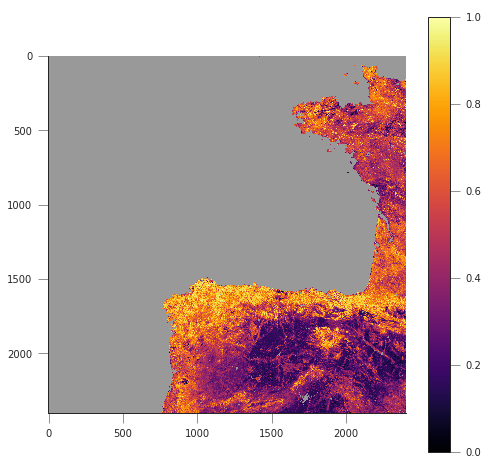

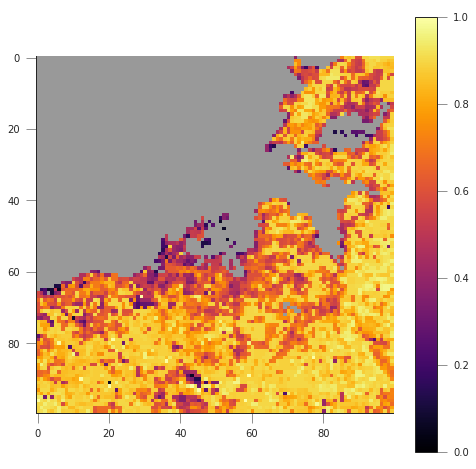

In [4]:
##################################################################
# Define transformations and variables. This is like above!
##################################################################

y_location, x_location = 43.3623, -8.4115 # In degs
# Define the Lat/Long object
wgs84 = osr.SpatialReference()
# In this case, we use EPSG code
wgs84.ImportFromEPSG(4326)
# Define the MODIS projection object
modis_sinu = osr.SpatialReference()
# In this case, we use the proj4 string
modis_sinu.ImportFromProj4("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 " + 
                           "+a=6371007.181 +b=6371007.181 +units=m +no_defs")

transformation = osr.CoordinateTransformation(wgs84, modis_sinu)
modis_x, modis_y, modis_z = transformation.TransformPoint(x_location, 
                                                         y_location)
print("MODIS coordinates: ", modis_x, modis_y)

##################################################################
# We use a random file in the UCL filesystem
##################################################################

fname = "/home/plewis/public_html/geog0111_data/lai_files/" + \
              "MCD15A3H.A2016273.h17v04.006.2016278070708.hdf"
g = gdal.Open('HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MCD15A3H:Fpar_500m' % fname)


##################################################################
# This is where new stuff begins
# Find out the pixel location from the MODIS Easting & Northing
##################################################################

geoT = g.GetGeoTransform()
inv_geoT = gdal.InvGeoTransform(geoT)
r, c = (gdal.ApplyGeoTransform(inv_geoT, modis_x, modis_y))
r = int(r+0.5)
c = int(c+0.5)
print("Pixel location: ", r,c)

##################################################################
# Now, read in the data, and plot it
##################################################################

fapar = g.ReadAsArray()/100
fapar[fapar>1] = np.nan
cmap = plt.cm.inferno
cmap.set_bad("0.6")
plt.figure(figsize=(8, 8))
plt.imshow(fapar, interpolation="nearest", vmin=0, vmax=1, cmap=cmap)
plt.colorbar()

##################################################################
# Plot a zoomed-in version
##################################################################


plt.figure(figsize=(8, 8))
plt.imshow(fapar[(c-50):(c+50), (r-50):(r+50)], interpolation="nearest",
           vmin=0, vmax=1, cmap=cmap)
plt.colorbar()


We can see that in the example above, we're getting the right pixel number. Clearly, the code above is a bit of a mess, and needs to be cleaned up, split into functions and tested. This is an example, and you can take this as a reference of how to document functions etc.

In [5]:
def convert_coordinates(x_location, y_location,
                       src_transform={'EPSG':4326},
                       dst_transform={'Proj4':
                                           "+proj=sinu +lon_0=0 +x_0=0 " + 
                                           "+y_0=0 +a=6371007.181 " + 
                                           "+b=6371007.181 +units=m +no_defs"
                                          }):
    """A function to convert coordinates from one target coordinate 
    representation to another. The input an output transformation can be given
    in either EPSG codes or Proj4 strings, by providing the function with a
    dictionary with the desired convention as a key, and with the relevant
    codes as its only element.
    
    Parameters
    ----------
    x_location: float
        The x location
    y_location: float
        The y location
    src_transform: dict
        A dictionary with keys either "EPSG" or "Proj4" (anything else throws
        an exception) with the description of the **input** projection
    dst_transform: dict
        A dictionary with keys either "EPSG" or "Proj4" (anything else throws
        an exception) with the description of the **output** projection
    Returns
    --------
    
    The transformed x and y coordinates"""
    input_coords = osr.SpatialReference()
    # In this case, we use EPSG code
    try:
        input_coords.ImportFromEPSG(src_transform["EPSG"])
    except KeyError:
        input_coords.ImportFromProj4(src_transform["Proj4"])
    except KeyError:
        raise ValueError("src_transform not dictionary with EPSG/Proj4 keys!")

        
    output_coords = osr.SpatialReference()
    try:
        output_coords.ImportFromEPSG(dst_transform["EPSG"])
    except KeyError:
        output_coords.ImportFromProj4(dst_transform["Proj4"])
    except KeyError:
        raise ValueError("src_transform not dictionary with EPSG/Proj4 keys!")


    transformation = osr.CoordinateTransformation(input_coords,
                                                 output_coords)
    output_x, output_y, output_z = transformation.TransformPoint(x_location, 
                                                         y_location)
    return output_x, output_y


##################################################################
# Test function
##################################################################

y_location, x_location = 43.3623, -8.4115 # In WGS84
print (convert_coordinates(x_location, y_location))




(-680000.4782137175, 4821673.202327191)


In [6]:
def get_pixel(raster, point_x, point_y):
    """Get the pixel for given coordinates (in the raster's convention, not
    checked!) for a raster file.
    
    Parameters
    ----------
    raster: string
        A GDAL-friendly raster filename
    point_x: float
        The Easting in the same coordinates as the raster (not checked!)
    point_y: float
        The Northing in the same coordinates as the raster (not checked!)

    Returns
    -------
    The row/column (or column/row, depending on how you define it)
    """
    g = gdal.Open(raster)
    if g is None:
        raise ValueError(f"{raster:s} cannot be opened!")
    geoT = g.GetGeoTransform()
    inv_geoT = gdal.InvGeoTransform(geoT)
    r, c = (gdal.ApplyGeoTransform(inv_geoT, point_x, point_y))
    return int(r + 0.5), int(c + 0.5)

##################################################################
# Test function
##################################################################


fname = "/home/plewis/public_html/geog0111_data/lai_files/" + \
              "MCD15A3H.A2016273.h17v04.006.2016278070708.hdf"
gdal_fname = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MCD15A3H:Fpar_500m' % fname
print (get_pixel(gdal_fname, -680000.4782137175, 4821673.202327191))

(932, 1593)


### Retrieving a time series from a multi-band raster

We have produced 4 rasters, with the LAI value for 2016 and 2017, as well as the correspodingn `FparLai_QC` layer. They're avaialable in `data/euro_lai`. Let's quickly have a look at the data:

In [7]:
success = procure_dataset("euro_lai", destination_folder="data/euro_lai/",
                         verbose=True)
if not success:
    print("Something happened copying files across to data/euro_lai")
    
print(gdal.Info("data/euro_lai/Europe_mosaic_Lai_500m_2017.tif").split("\n")[:10])

Running on UCL's Geography computers
trying /archive/rsu_raid_0/plewis/public_html/geog0111_data
trying /data/selene/ucfajlg/geog0111_data/lai_data/
trying /data/selene/ucfajlg/geog0111_data/
Linking /data/selene/ucfajlg/geog0111_data/euro_lai/Europe_mosaic_FparLai_QC_2016.tif to data/euro_lai/Europe_mosaic_FparLai_QC_2016.tif
Linking /data/selene/ucfajlg/geog0111_data/euro_lai/Europe_mosaic_FparLai_QC_2017.tif to data/euro_lai/Europe_mosaic_FparLai_QC_2017.tif
Linking /data/selene/ucfajlg/geog0111_data/euro_lai/Europe_mosaic_Lai_500m_2016.tif to data/euro_lai/Europe_mosaic_Lai_500m_2016.tif
Linking /data/selene/ucfajlg/geog0111_data/euro_lai/Europe_mosaic_Lai_500m_2017.tif to data/euro_lai/Europe_mosaic_Lai_500m_2017.tif
['Driver: GTiff/GeoTIFF', 'Files: data/euro_lai/Europe_mosaic_Lai_500m_2017.tif', 'Size is 4800, 4800', 'Coordinate System is:', 'PROJCS["unnamed",', '    GEOGCS["Unknown datum based upon the custom spheroid",', '        DATUM["Not_specified_based_on_custom_spheroid",

We have 90 (or 91) layers, from day 1 to day 360/364 in the year. While we could read all the data in memory, it's wasteful of resources, and we might as well try to read in all the bands for a given pixel. 

We can do this with the `read_tseries` function below. Basically, we this function calls the previous pixel-location functions, and then reads the entire time series for a pixel in one go. The function is defined below:

In [8]:
def read_tseries(raster, lat, long):
    """Read a time series (or all bands) for a raster file given latitude and
    longitude coordinates.
    **NOTE** Only works with Byte/UInt8 data types!
    """
    g = gdal.Open(raster)
    px, py = get_pixel(raster, *convert_coordinates(long, lat))
    if 0 <= px >= g.RasterXSize:
        raise ValueError(f"Point outside of raster ({px:d}/{g.RasterXSize:d})")
    if 0 <= py >= g.RasterYSize:
        raise ValueError(f"Point outside of raster ({py:d}/{g.RasterYSize:d})")

    xbuf = 1
    ybuf = 1
    n_doys = g.RasterCount
    buf = g.ReadRaster (px, py,
                xbuf, ybuf, buf_xsize=xbuf, buf_ysize=ybuf, 
                band_list=np.arange (1, n_doys+1))
    data = np.frombuffer ( buf, dtype=np.uint8)
    return data



The Nature reserve of [Muniellos](https://en.wikipedia.org/wiki/Muniellos_Nature_Reserve) (43.0156, -6.7038) is mostly populated by *Quercus Robur*, which shows a strong phenology. It should be a good test point to see whether the data we have is sensible or not.

<div class="alert alert-danger">
<p>Using the provided function, plot the time series of LAI over the Muniellos Reserve for 2016 and 2017. Extra points for using QA flags to filter the data</p>
</div>

In [10]:
%%html

<div>
     <iframe width="500" height="400" frameborder="0" src="https://www.bing.com/maps/embed?h=400&w=500&cp=43.029897999999996~-6.734863999999996&lvl=11&typ=d&sty=h&src=SHELL&FORM=MBEDV8" scrolling="no">
     </iframe>
     <div style="white-space: nowrap; text-align: center; width: 500px; padding: 6px 0;">
        <a id="largeMapLink" target="_blank" href="https://www.bing.com/maps?cp=43.029897999999996~-6.734863999999996&amp;sty=h&amp;lvl=11&amp;FORM=MBEDLD">View Larger Map</a> &nbsp; | &nbsp;
        <a id="dirMapLink" target="_blank" href="https://www.bing.com/maps/directions?cp=43.029897999999996~-6.734863999999996&amp;sty=h&amp;lvl=11&amp;rtp=~pos.43.029897999999996_-6.734863999999996____&amp;FORM=MBEDLD">Get Directions</a>
    </div>
</div>

We can now try to fit our double logistic model to the observations, weighted by their uncertainty. We make use the previously defined functions for the model and the cost function that we defined above. We will start by fitting the data to 2016, but will also try to "eyeball" a good starting point for the optimisation. And obviously, we'll want some plots...

A nice way to plot points with errorbars is (surprisingly enought) the [`plt.errorbar` method](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.errorbar.html). It's like the `plt.plot` method, but it also takes a `yerr` (or `xerr`) keyword with the extent of the error in the $y$ direction.

Cost:  173.30984000080434
Cost:  89.70477658818041
Value of the function at the minimum: 43.7381
Value of the solution: [4.61179571e-01 5.04359055e+00 1.24979141e-01 1.26813992e+02
 9.04932760e-02 2.68361852e+02]


Text(0.5,0,'DoY [d]')

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


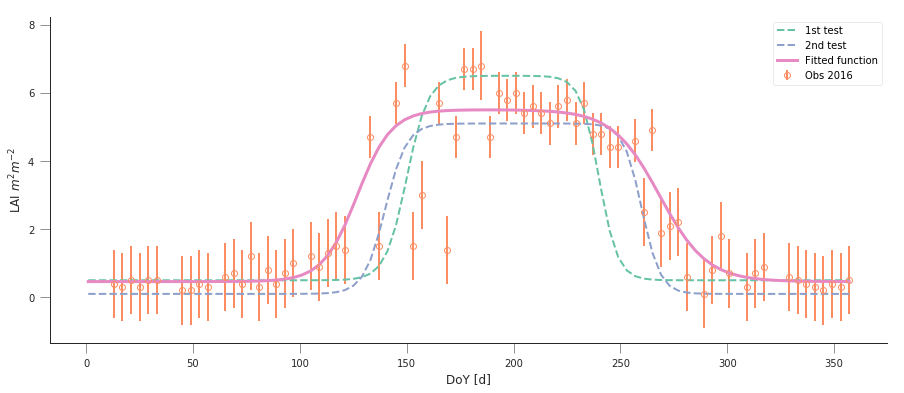

In [9]:
from scipy.optimize import minimize

plt.figure(figsize=(15, 6))
y_location, x_location = 43.0156, -6.7038
##################################################################
# Start by reading in the data
##################################################################
# Filenames
year = 2016
lai_raster = f"data/euro_lai/Europe_mosaic_Lai_500m_{year:d}.tif"
qa_raster = f"data/euro_lai/Europe_mosaic_FparLai_QC_{year:d}.tif"
# Actually read the data
data = read_tseries(lai_raster, y_location, x_location)/10. # Read LAI
qa = read_tseries(qa_raster, y_location, x_location) # Read QA/QC
# We only want to use QA flags 0 or 1
passer = get_sfc_qc(qa) <= 1
# This is the uncertainty
sigma = get_scaling(get_sfc_qc(qa))[passer]
# This is the time axis: every 4 days
t = np.arange(len(passer))*4 + 1

##################################################################
# Plot the observations of LAI with uncertainty bands
##################################################################

plt.errorbar(t[passer], data[passer], yerr=sigma, fmt="o", 
             mfc="none", label=f"Obs {year:d}")

##################################################################
# Plot a first prediction with some random model parameters
##################################################################
# First eyeballing test:
p0 = np.array([0.5, 6, 0.2, 150, 0.23, 240])
plt.plot(t, dbl_sigmoid_function(p0, t), '--', label="1st test")
print("Cost: ",
      cost_function(p0, t, data[passer], passer, sigma))

##################################################################
# Plot a second, more refined prediction
##################################################################

# Second eyeballing test:
p0 = np.array([0.1, 5, 0.2, 140, 0.23, 260])
plt.plot(t, dbl_sigmoid_function(p0, t), '--', label="2nd test")
print("Cost: ", 
      cost_function(p0, t, data[passer], passer, sigma))

##################################################################
# Do the minimisation starting from the second prediction
##################################################################

# Now, minimise based on the second test, which appears better

retval2016 = minimize(cost_function, p0, args=(t, data[passer], 
                                               passer, sigma))

print(f"Value of the function at the minimum: {retval2016.fun:g}")
print(f"Value of the solution: {str(retval2016.x):s}")

##################################################################
# Plot the fitted model
##################################################################

plt.plot(t, dbl_sigmoid_function(retval2016.x, t), '-', lw=3,
         label="Fitted function")
plt.legend(loc="best")
plt.ylabel("LAI $m^{2}m^{-2}$")
plt.xlabel("DoY [d]")

A model isn't very useful if you can't use it to make predictions. So let's just use the optimal solution to predict the LAI for 2017:

Text(0.5,0,'DoY [d]')

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


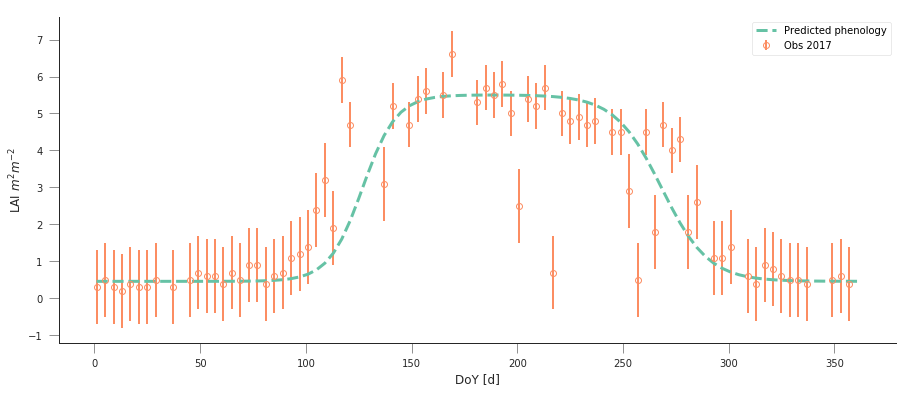

In [11]:
plt.figure(figsize=(15, 6))

year = 2017
lai_raster = f"data/euro_lai/Europe_mosaic_Lai_500m_{year:d}.tif"
qa_raster = f"data/euro_lai/Europe_mosaic_FparLai_QC_{year:d}.tif"

data = read_tseries(lai_raster, y_location, x_location)/10.
qa = read_tseries(qa_raster, y_location, x_location)
passer = get_sfc_qc(qa) <= 1
sigma = get_scaling(get_sfc_qc(qa))[passer]

t = np.arange(len(passer))*4 + 1

# Plot the data with uncertainty bars
plt.errorbar(t[passer], data[passer], yerr=sigma, fmt="o", 
             mfc="none", label=f"Obs {year:d}")

# Print the fitted model    
plt.plot(t, dbl_sigmoid_function(retval2016.x, t), '--', lw=3,
         label="Predicted phenology")
plt.legend(loc="best")
plt.ylabel("LAI $m^{2}m^{-2}$")
plt.xlabel("DoY [d]")

The results are very encouraging, but given the large error bars, and the paucity of data in spring and autumn, can we be sure? We could definitely compare the fit from last year to the fit from this year and see whether they're different. But it'll be hard to decide whether they are different or not if we don't have error bars in the parameters!

<div class="alert alert-danger">
<p>Fit the phenology model to the 2017 data, and comment on the optimal parameters</p>
</div>

<div class="alert alert-danger">
<p>Do a similar experiment for other sites. In the benefit of efficiency, you could write a set of functions that would allow you to quickly do the entire process and relevant plots for different latitude/longitude points</p>
</div>


<div class="alert alert-success">
Some quick notions on how to develop the functions:
<ol>
    <li>You probably want a read data function, that returns LAI, `sigma` and `passer`.</li>
    <li>A second function could take the data and a starting guess, and minimise it, returning the optimal parameters.</li>
    <li>A third function would be in charge of plotting the data, and the predictions, so it could take the observations and uncertainties, etc., as well as a vector of parameters.</li>
    <li>A final function could wrap the previous three and allow the user to select a year to fit to and a location</li>
</ol>
</div>

You can probably come up with interesting sites, but here are some that you **may** want to try
```python
sites = [[43.015364, -6.703704], 
         [51.775511, -1.336993],
         [43.487178, 1.283292]
        ]
```

## Uncertainty

In the previous examples, we have seen that the model can be made to fit observations and used in prediction pretty well, but there's the obvious question of how exactly can we define the different parameters. Ideally, we'd like to have some error bars on e.g. the date and slope of the spring and autumn flanks, so that we can decide whether a shift has ocurred or not. Similarly for the maximum/minimum LAI. Intuitively, we can see that if we change the optimal parameters a bit, we'll get a solution that might still have an acceptable performance (meaning that it will probably go through all the error bars).

One way to test this is to do some Monte Carlo sampling around the optimal solution. We can evaluate the shape of the cost function around the optimum and that will give us an idea of the uncertainty: a cost function that changes very rapidly around the optimal point in one direction suggests that if you change the parameters by a small amount, the goodness of fit changes drastically, so that the parameter is very well and accurately defined. In contrast, if changing the parameter doesn't change the cost function value by much, we have an uncertain parameter.

### The Metropolis-Hastings algorithm

A way to do this Monte Carlo sampling is to use the Metropolis-Hastings algorithm. This is a sequential method that proposes and accepts samples based on the likelihood value. Basically, if the cost function improves, the sample gets accepted, if it doesn't improve, then a uniform random number between 0 and 1 is drawn. If the ratio of proposed to previous likelihoods is greater than the random number, the samples gets accepted. This means that for solutions that don't improve the cost function, there's a chance that the algorithm will improve on them, meaning that it doesn't get trapped on local minima, and provides an exploration of the entire problem space.

In a nutshell, here's some **pseudocode** of the MH algorithm

1. Initialise $\vec{x}^{0}$.
2. For $i=1$ to $i=N_{iterations}$:
    a. Sample a proposed new $\vec{x}^{*}$ as  $\vec{x}^{*}=\vec{x}^{i-1} + \mathcal{N}(0, \Sigma)$.
    
    b. Calculate the **likelihood** associated with $\vec{x}^{*}$, $L(\vec{x}^{*}, i)$.
    
    c. Calculate the **likelihood ratio** $\alpha=\displaystyle{\frac{L(\vec{x}^{*}, i)}{L(\vec{x}^{*}, i-1)}}$.
    
    d. Draw a random uniform number between 0 and 1 $u=\mathcal{U}(0,1)$
    
    e. if $u\le \min\left\lbrace 1, \alpha\right\rbrace$:
       
      * $\vec{x}^{i+1} = \vec{x}^{*}$: we accept the new proposal
    
    f. else:
      * $\vec{x}^{i+1} = \vec{x}^{i}$: we reject the new proposal


<div class="alert alert-success">
<p> Examine the MH algorithm, and try to see whether you can see how you could go and implement it in Python. The pseudocode above presents you with the barebones recipe, and you will need to add a couple of extra ingredients. You can assume that you have available the **log-likelihood** function that we have described above, and you may need to use the `np.random.normal` and `np.random.rand` functions which respectively provide Gaussian random numbers and uniform random numbers between 0 and 1

</div>


In [ ]:
y_location, x_location = 43.0156, -6.7038

def read_data(year, x_location, y_location):
    lai_raster = f"data/euro_lai/Europe_mosaic_Lai_500m_{year:d}.tif"
    qa_raster = f"data/euro_lai/Europe_mosaic_FparLai_QC_{year:d}.tif"
    print(lai_raster)
    data = read_tseries(lai_raster, y_location, x_location)/10.
    qa = read_tseries(qa_raster, y_location, x_location)
    passer = get_sfc_qc(qa) <= 1
    sigma = get_scaling(get_sfc_qc(qa))[passer]

    t = np.arange(len(passer))*4 + 1
    return t, data, sigma, passer

def lklhood(p, t, y_obs, passer, sigma_obs, func=dbl_sigmoid_function):
    y_pred = func(p, t)
    n = passer.sum()
    cost = -0.5* (y_pred[passer]-y_obs)**2/sigma_obs**2
    return cost.sum()
    

samples = metropolis_hastings(retval2016.x, 2016, x_location, y_location)

The previous code has produced samples of parameters that we can now visualise as "traces" as well as histograms. The shape of the histograms gives us some idea of the uncertainty of the parameters in their units. We can also use these samples and propagate them through the phenology model to produce an *ensemble* of model trajectories that define a region of uncertainty.

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


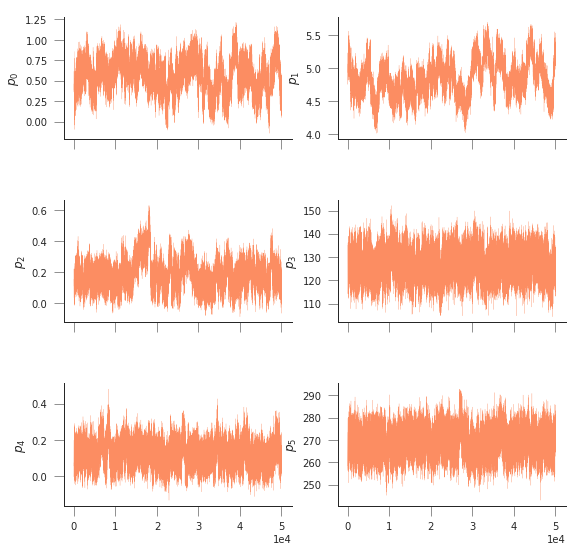

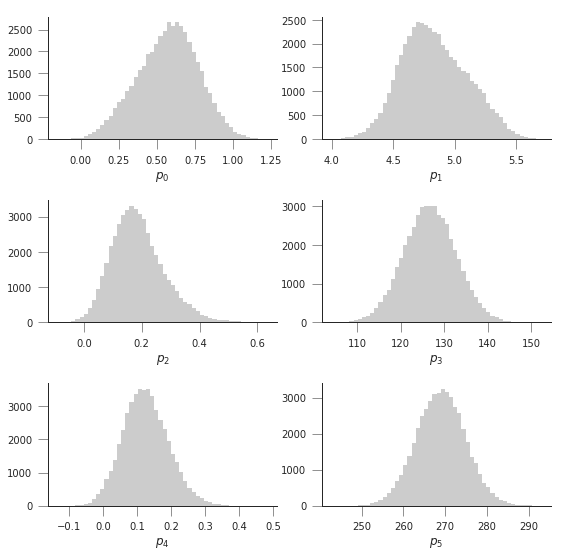

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), sharex=True)
axs = axs.flatten()
for i in range(len(retval2016.x)):
    axs[i].plot(samples[:, i], '-', lw=0.2)
    axs[i].set_ylabel(f"$p_{i}$")
    
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
axs = axs.flatten()
for i in range(len(retval2016.x)):
    axs[i].hist(samples[2000:, i], bins=50, color="0.8")
    axs[i].set_xlabel(f"$p_{i}$")


data/euro_lai/Europe_mosaic_Lai_500m_2016.tif


Text(0.5,0,'DoY [d]')

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


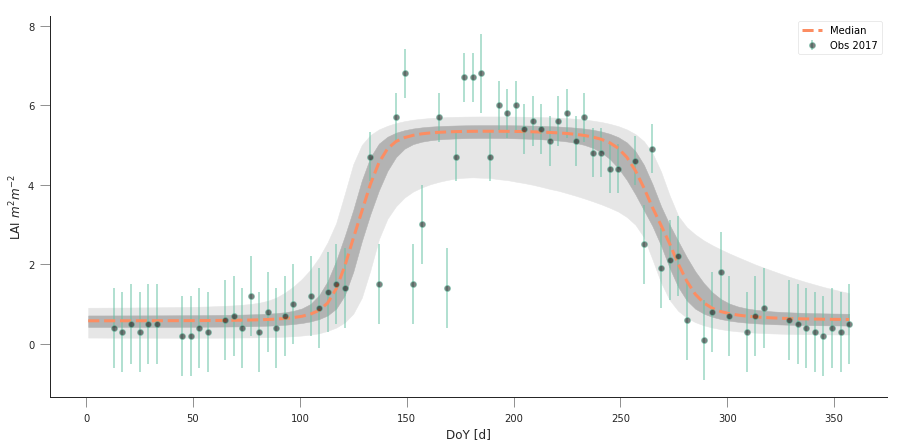

In [18]:
n_samples = samples.shape[0]
y_location, x_location = 43.0156, -6.7038

t, data, sigma, passer = read_data(2016, x_location, y_location)

pred_lai = np.zeros((n_samples, len(t)))
for i in range(n_samples):
    pred_lai[i, :] = dbl_sigmoid_function(samples[i], t)

    
plt.figure(figsize=(15, 7))
pcntiles = np.percentile( pred_lai, [5, 25, 50, 75, 95], axis=0)
plt.fill_between(t, pcntiles[0], pcntiles[-1], color="0.9")
plt.fill_between(t, pcntiles[1], pcntiles[-2], color="0.7")
plt.plot(t, pcntiles[2], '--', lw=3, label="Median")

plt.errorbar(t[passer], data[passer], yerr=sigma, fmt="o", 
             mfc="none", label=f"Obs {year:d}", alpha=0.5)

plt.legend(loc="best")
plt.ylabel("LAI $m^{2}m^{-2}$")
plt.xlabel("DoY [d]")